In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 1
macro_configs = config_generator(f_modes=[0.05, 0.07, 0.1, 0.2, 0.8, 1, 5],
                                 g=[20, 2, 10, 20],
                                 somp=[False, True])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [3]:
N = 2000
K = int(params['f_modes'] * N)
#Random modes
U = np.random.normal(0, 1/np.sqrt(N), (N, K))
VT = np.random.normal(0, 1/np.sqrt(N), (K, N))

g_eff = params['g']
#f_cutoff = params['f_cutoff']
S = np.ones(K)
#S[int(f_cutoff*N):] = 0
S = g_eff * S / np.sqrt((S**2).sum()/N)

#W = U.dot(np.diag(S)).dot(VT)
W = np.einsum('ik, k, kj -> ij', U, S, VT)
del U
del VT
if params['somp'] or True:
    W = g_eff*np.random.normal(0, 1/np.sqrt(N), (N, N))

In [4]:
W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)
dt = 0.1
dt_save = 1
#x, r_lpf = run_torch_sim(20000, dt_save, dt, W_)
cov = run_online_cov_sim(20000, dt_save, dt, W_, N_batch=1, T_save_delay=100,
                         dt_PR=1, compute_PRs=False)
#dt_save = 0.05
#x, r_lpf = run_torch_sim(5000, dt_save, dt, W_)

In [ ]:
phi_numpy = lambda x: erf((np.sqrt(np.pi)/2)*x)
r = phi_numpy(x)

In [16]:
cov_copy = cov.copy()
np.fill_diagonal(cov_copy, np.nan)
fcov = cov_copy.flatten()
ccov = fcov[~np.isnan(fcov)]

(array([3.57581275e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.57581275e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.57581275e-06, 3.57581275e-06, 3.57581275e-06,
        7.15167425e-06, 1.07274382e-05, 0.00000000e+00, 3.57581275e-06,
        3.57583712e-06, 3.57581275e-06, 1.78790637e-05, 7.15167425e-06,
        1.07274382e-05, 1.07274382e-05, 2.50306892e-05, 3.21825341e-05,
        2.86065020e-05, 1.07274382e-05, 3.57583712e-05, 3.21823147e-05,
        6.43646294e-05, 7.50920677e-05, 6.43650682e-05, 8.58195059e-05,
        1.03698570e-04, 1.53759948e-04, 1.35881811e-04, 1.78790637e-04,
        1.53759948e-04, 1.71640182e-04, 1.75214825e-04, 2.14548765e-04,
        3.07519896e-04, 3.39704527e-04, 4.21945904e-04, 5.68554227e-04,
        6.29347334e-04, 6.79404422e-04, 8.29588557e-04, 8.72498310e-04,
        1.14784372e-03, 1.20504890e-03, 1.67348037e-03, 1.77003334e-03,
        2.14907079e-03, 2.56028193e-03, 3.22181827e-03, 3.683087

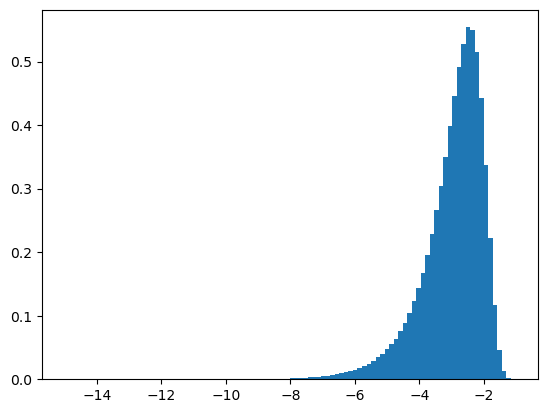

In [17]:
plt.hist(np.log10(ccov**2), bins=100, density=True)

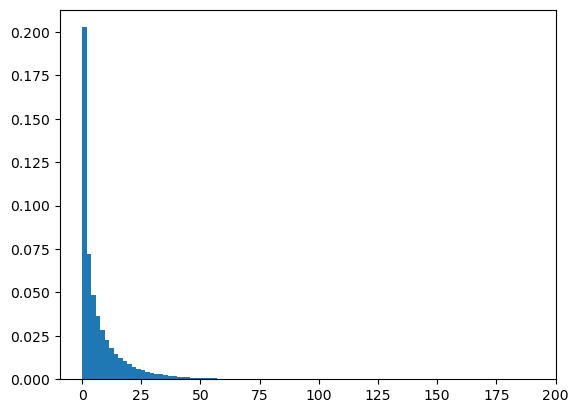

In [20]:
_ = plt.hist(N*(ccov**2), bins=100, density=True)

In [18]:
psi = N * np.mean(ccov**2)
C02 = np.trace(cov**2)/N
C02/(C02 + psi)

0.1083878143611463

In [ ]:
if False:
    X = r
    T, N = X.shape
    F_train, G_train = X[:T//2,:N//2], X[:T//2,N//2:]
    F_test, G_test = X[T//2:,:N//2], X[T//2:,N//2:]

    C = F_train.T.dot(G_train) / (T//2 - 1)
    U, S, VT = np.linalg.svd(C)
    UF = U.T.dot(F_test.T)
    GV = G_test.dot(VT.T)
    Sk = np.einsum('kt, tk -> k', UF, GV)

    UF1 = U.T.dot(F_test.T)
    FU1 = F_test.dot(U)
    Sk_tot_1 = np.einsum('kt, tk -> k', UF1, FU1)
    VG2 = VT.dot(G_test.T)
    GV2 = G_test.dot(VT)
    Sk_tot_2 = np.einsum('kt, tk -> k', VG2, GV2)
    Sk_tot = Sk_tot_1 + Sk_tot_2
    #percent_reliable_var = (Sk/(T//2)/(Sk_tot/(T//2)))
    prv = Sk / Sk_tot

In [ ]:
#C_phi_emp = np.fft.irfft((np.abs(np.fft.rfft(r, axis=0, norm='ortho'))**2).mean(1))
#time_emp = np.arange(0, 50, dt_save)

In [ ]:
cov = r.T.dot(r)/(r.shape[0] - 1)
eigs, vecs = np.linalg.eig(cov)

In [ ]:
#plt.plot(sorted(np.abs(eigs))[::-1], '.')
#plt.xscale('log')
#plt.yscale('log')
#plt.axvline(x=0.2*N, color='k')

In [ ]:
eigs = np.array(sorted(np.abs(eigs))[::-1])
processed_data = eigs
#prvs = np.zeros_like(eigs)
#prvs[:len(prv)] = prv
#processed_data = np.array([eigs, prvs])
#processed_data = C_phi_emp[:len(time_emp)]

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [4]:
###Truncate file above
file_name = 'USV_power_spectra'
job_name = 'n=4k_usv_spectra'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook USV_power_spectra.ipynb to script
[NbConvertApp] Writing 13157 bytes to USV_power_spectra.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b2b133156d0> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b2b133156d0> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [5]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=16, n_hours=1, n_gpus=1)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/n=4k_usv_spectra/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/cluster/
mft-theory/cluster/__init__.py
mft-theory/cluster/close_jupyter_notebook.py
mft-theory/cluster/process_results.py
mft-theory/cluster/start_jupyter_notebook.py
mft-theory/cluster/submit_jobs.py
mft-theory/cluster/sync_cluster.py
mft-theory/core/
mft-theory/core/Simulation.py
mft-theory/core/Time_Cts_RNN.py
mft-theory/core/Torch_S

In [14]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           3047004    lkumar  jupyter   om2382  R      56:28      1 ax16


In [15]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'n=4k_usv_spectra'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

In [ ]:
!ls -t ../job_scripts/

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8,4))
time_emp = np.arange(0, 50, 0.05)
for i in range(2):
    for j in range(2):
        if i == 0:
            ax[i,j].set_title('g = {}'.format(configs_array['g'][j]))
        if j == 0:
            ax[i,j].set_ylabel('f mode = {}'.format(np.round(configs_array['f_modes'][i],2)))
        for k in range(2):
            ax[i,j].plot(time_emp, results_array[i,j,k,:,:].mean(0), color='C{}'.format(2*k), alpha=1)
        for k in range(2):
            for i_seed in range(20):
                #Plot spectrum and best fit up to cutoff
                ax[i,j].plot(time_emp, results_array[i,j,k,i_seed,:], color='C{}'.format(2*k), alpha=0.08)
        ax[i,j].set_ylim([-0.05, 0.05])
        #ax[i,j].set_xticks([])
ax[0,0].legend(['USV', 'Somp'])

In [ ]:
from scipy.stats import linregress
fig, ax = plt.subplots(5, 3, figsize=(10, 16))
N = 4000
for i in range(5):
    for j in range(3):
        if i == 0:
            ax[i,j].set_title('g = {}'.format(configs_array['g'][j]))
        if j == 0:
            ax[i,j].set_ylabel('f mode = {}'.format(np.round(configs_array['f_modes'][i],2)))
        for k in range(1):
            #Plot spectrum and best fit up to cutoff
            s = results_array[i,j,k,0,0,:]
            N_cutoff = int(configs_array['f_modes'][i]*N)
            r_shift = 10
            logs = np.log10(s)[r_shift:N_cutoff]
            x = np.arange(r_shift, len(logs) + r_shift)
            logx = np.log10(x)
            res = linregress(logx, logs)

            ax[i,j].plot(s, '.', color='C{}'.format(2*k))
            ax[i,j].plot(x, 10**(res.intercept) * x**(res.slope), color='k')
            if k == 0:
                ax[i,j].plot(10**results_array[i,j,k,0,1,:], color='m')
            ax[i,j].set_ylim([0.01, 1000])
            ax[i,j].set_xlim([1, N*5])
            if k==0 and i==0:
                ax[i,j].set_title(r'$\alpha = {}, g = {}$'.format(np.round(res.slope, 2), configs_array['g'][j]))
            elif k==0:
                ax[i,j].set_title(r'$\alpha = {}$'.format(np.round(res.slope, 2)))
            ax[i,j].set_xscale('log')
            ax[i,j].set_yscale('log')
            ax[i,j].set_xticks([])
            ax[i,j].axvline(x=N_cutoff, color='k', linestyle='--')
ax[0,0].legend(['Cov spec', '_fits', 'PRV'])

In [ ]:
fig.savefig('figs/spec_prv_usv.png', dpi=300)

In [ ]:
results_array.shape

/tmp/ipykernel_57180/2473578652.py:32: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax[0,0].legend(['USV', '_fits', '_cutoff', 'Somp'])


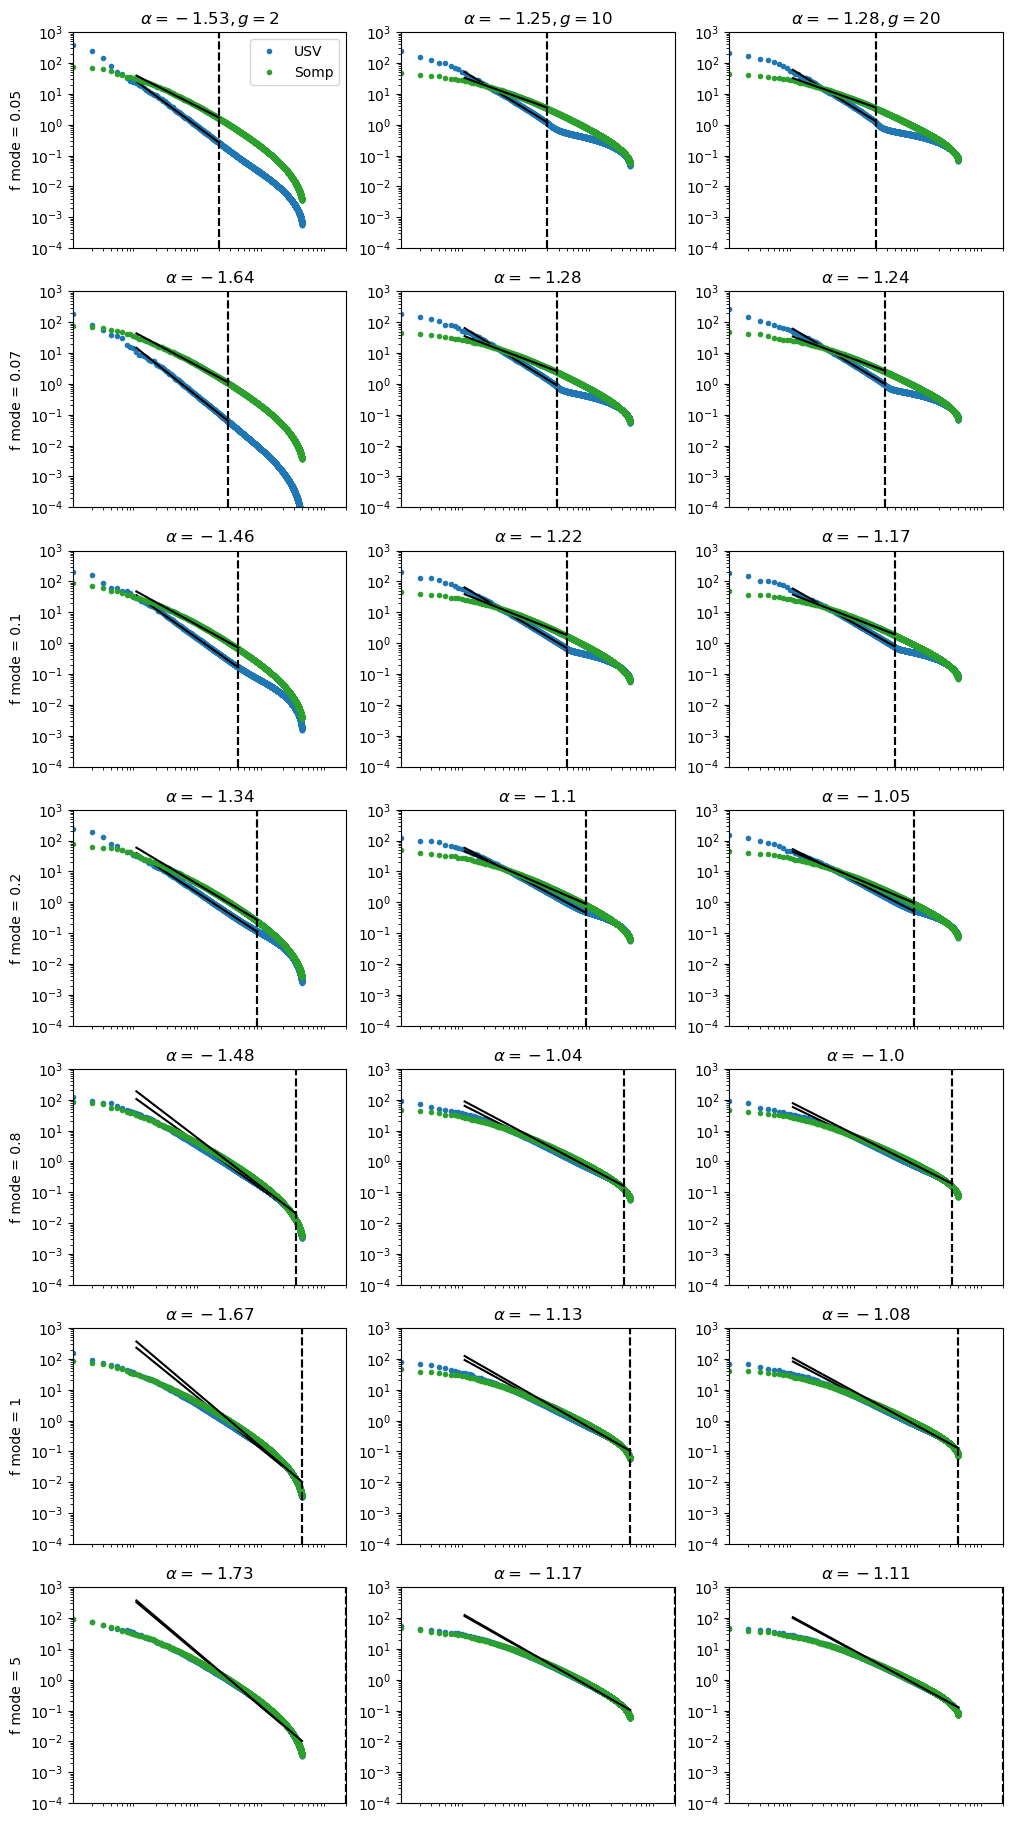

In [17]:
from scipy.stats import linregress
fig, ax = plt.subplots(7, 3, figsize=(12, 23))
N = 4000
for i in range(7):
    for j in range(3):
        if i == 0:
            ax[i,j].set_title('g = {}'.format(configs_array['g'][j]))
        if j == 0:
            ax[i,j].set_ylabel('f mode = {}'.format(np.round(configs_array['f_modes'][i],2)))
        for k in range(2):
            #Plot spectrum and best fit up to cutoff
            s = results_array[i,j,k,0,:]
            N_cutoff = int(configs_array['f_modes'][i]*N)
            r_shift = 10
            logs = np.log10(s)[r_shift:N_cutoff]
            x = np.arange(r_shift, len(logs) + r_shift)
            logx = np.log10(x)
            res = linregress(logx, logs)

            ax[i,j].plot(s, '.', color='C{}'.format(2*k))
            ax[i,j].plot(x, 10**(res.intercept) * x**(res.slope), color='k')
            ax[i,j].set_ylim([0.0001, 1000])
            ax[i,j].set_xlim([1, N*5])
            if k==0 and i==0:
                ax[i,j].set_title(r'$\alpha = {}, g = {}$'.format(np.round(res.slope, 2), configs_array['g'][j]))
            elif k==0:
                ax[i,j].set_title(r'$\alpha = {}$'.format(np.round(res.slope, 2)))
            ax[i,j].set_xscale('log')
            ax[i,j].set_yscale('log')
            ax[i,j].set_xticks([])
            ax[i,j].axvline(x=N_cutoff, color='k', linestyle='--')
ax[0,0].legend(['USV', '_fits', '_cutoff', 'Somp'])

In [ ]:
fig.savefig('figs/fmode_spectra.png', dpi=300)

In [ ]:
from scipy.stats import linregress
fig, ax = plt.subplots(9, 3, figsize=(12, 25))
N = 2000
for i in range(9):
    for j in range(3):
        if i == 0:
            ax[i,j].set_title('g = {}'.format(configs_array['g'][j]))
        if j == 0:
            ax[i,j].set_ylabel('f cutoff = {}'.format(np.round(configs_array['f_cutoff'][i],2)))
        for k in range(2):
            #Plot spectrum and best fit up to cutoff
            s = results_array[i,j,k,0,:400]
            ax[i,j].plot(s, color='C{}'.format(2*k))
            ax[i,j].set_ylim([0, 1.1])
            ax[i,j].set_xticks([])
ax[0,0].legend(['USV', 'Somp'])
fig.savefig('figs/usv_somp_autocov_match.pdf')

In [ ]:
from scipy.stats import linregress
fig, ax = plt.subplots(9, 3, figsize=(12, 25))
N = 2000
for i in range(9):
    for j in range(3):
        for k in range(2):
            #Plot spectrum and best fit up to cutoff
            s = results_array[i,j,k,0,:]
            N_cutoff = int(configs_array['f_cutoff'][i]*N)
            r_shift = 10
            logs = np.log10(s)[r_shift:N_cutoff]
            x = np.arange(r_shift, len(logs) + r_shift)
            logx = np.log10(x)
            res = linregress(logx, logs)

            ax[i,j].plot(s, '.', color='C{}'.format(2*k))
            ax[i,j].plot(x, 10**(res.intercept) * x**(res.slope), color='k')
            ax[i,j].set_ylim([0.01, 1000])
            if k==0:
                ax[i,j].set_title(r'$\alpha = {}$'.format(np.round(res.slope, 2)))
            ax[i,j].set_xscale('log')
            ax[i,j].set_yscale('log')
            ax[i,j].set_xticks([])
            ax[i,j].axvline(x=N_cutoff, color='k', linestyle='--')

In [ ]:
from scipy.stats import linregress
fig, ax = plt.subplots(18, 1, figsize=(5, 40))
N = 2000
for i in range(18):
    #Plot spectrum and best fit up to cutoff
    s = results_array[i,0,:]
    N_cutoff = int(configs_array['f_cutoff'][i]*N)
    r_shift = 10
    logs = np.log10(s)[r_shift:N_cutoff]
    x = np.arange(r_shift, len(logs) + r_shift)
    logx = np.log10(x)
    res = linregress(logx, logs)
    
    ax[i].plot(s, '.', color='C0')
    ax[i].plot(x, 10**(res.intercept) * x**(res.slope), color='C1')
    ax[i].set_ylim([0.01, 1000])
    ax[i].set_title(r'$\alpha = {}$'.format(np.round(res.slope, 2)))
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].axvline(x=N_cutoff, color='k', linestyle='--')

In [ ]:
from scipy.stats import linregress
fig, ax = plt.subplots(18, 7, figsize=(20, 40))
N = 2000
for i in range(18):
    for j in range(7):
        #Plot spectrum and best fit up to cutoff
        s = results_array[i,j,0,:]
        N_cutoff = int(configs_array['f_cutoff'][i]*N)
        r_shift = 10
        logs = np.log10(s)[r_shift:N_cutoff]
        x = np.arange(r_shift, len(logs) + r_shift)
        logx = np.log10(x)
        res = linregress(logx, logs)

        ax[i,j].plot(s, '.', color='C0')
        ax[i,j].plot(x, 10**(res.intercept) * x**(res.slope), color='C1')
        ax[i,j].set_ylim([0.01, 1000])
        ax[i,j].set_title(r'$\alpha = {}$'.format(np.round(res.slope, 2)))
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_xticks([])
        ax[i,j].axvline(x=N_cutoff, color='k', linestyle='--')

In [ ]:
from scipy.stats import linregress
fig, ax = plt.subplots(3, 4, figsize=(8, 6))
N = 2000
for i_ax, i in enumerate([0, 4, 16]):
    for j_ax, j in enumerate([0, 2, 4, 6]):
        #Plot spectrum and best fit up to cutoff
        s = results_array[i,j,0,:]
        N_cutoff = int(configs_array['f_cutoff'][i]*N)
        r_shift = 10
        logs = np.log10(s)[r_shift:N_cutoff]
        x = np.arange(r_shift, len(logs) + r_shift)
        logx = np.log10(x)
        res = linregress(logx, logs)

        ax[i_ax,j_ax].plot(s, '.', color='C0')
        ax[i_ax,j_ax].plot(x, 10**(res.intercept) * x**(res.slope), color='C1')
        ax[i_ax,j_ax].set_ylim([0.01, 1000])
        ax[i_ax,j_ax].set_title(r'$\alpha = {}$'.format(np.round(res.slope, 2)))
        if i_ax == 0:
            ax[i_ax,j_ax].set_title(r'$\alpha = {}, g = {}$'.format(np.round(res.slope, 2),
                                                                    configs_array['g'][j]))
        if j_ax == 0:
            ax[i_ax, j_ax].set_ylabel(r'$f_c = {}$'.format(np.round(configs_array['f_cutoff'][i], 2)))
        ax[i_ax,j_ax].set_xscale('log')
        ax[i_ax,j_ax].set_yscale('log')
        ax[i_ax,j_ax].set_xticks([])
        ax[i_ax,j_ax].axvline(x=N_cutoff, color='k', linestyle='--')

In [ ]:
fig.savefig('figs/spectral_cutoffs_small.pdf', dpi=300)

In [ ]:
vals = np.squeeze(results_array)
vals.sum(1)**2 / (vals**2).sum(1) / N